# **`Artificial Neural Network`**

Nama Anggota :
1. Achmad Ata Irsyadudin (21102013)
2. Aditya Setiawan (21102034)



1.   Import Library



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


2.   Preprocessing Data

a. Load Dataset


In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
columns = ["vendor_name", "model_name", "MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX", "PRP", "ERP"]

data = pd.read_csv(url, names=columns)

# Drop irrelevant columns
data = data.drop(columns=["vendor_name", "model_name"])

# Split features (X) and target (y)
X = data.drop(columns=["ERP"]) # nilai bahan prediksi y
y = data["ERP"] #hasil prediksi ERP dari x

b. Data Preprocessing

In [3]:
# Train-test split
#data untuk testing=20%, data training=80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

3. Bangun Model ANN

In [4]:
class BaselineANN(nn.Module):
    def __init__(self, input_size):
        super(BaselineANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
baseline_model = BaselineANN(input_size=X_train.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001) 

4. Define Loss Function dan Optimizer

In [5]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)  # Adam optimizer


5. Training Model Baseline

In [6]:
# Training Loop for Baseline Model
epochs = 100
for epoch in range(epochs):
    baseline_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = baseline_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 10/100, Loss: 23024.7259
Epoch 20/100, Loss: 22466.7675
Epoch 30/100, Loss: 22106.2312
Epoch 40/100, Loss: 20481.3803
Epoch 50/100, Loss: 16538.8150
Epoch 60/100, Loss: 12543.4178
Epoch 70/100, Loss: 9362.2785
Epoch 80/100, Loss: 6303.8490
Epoch 90/100, Loss: 4194.8080
Epoch 100/100, Loss: 2769.3800


6. Eksplorasi Model
(model 1: ANN dengan Dropout dan Hidden Layers lebih dalam)

In [7]:
class ANNModel1(nn.Module):
    def __init__(self, input_size):
        super(ANNModel1, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model 1
model1 = ANNModel1(input_size=X_train.shape[1])
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

Model 2: ANN dengan Hidden Layers Dangkal dan Tanpa Dropout

In [14]:
class ANNModel2(nn.Module):
    def __init__(self, input_size):
        super(ANNModel2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model 2
model2 = ANNModel2(input_size=X_train.shape[1])
optimizer2 = optim.Adam(model2.parameters(), lr=0.005)  # Learning rate lebih tinggi

Model 3: ANN dengan Learning Rate Rendah dan Dropout

In [15]:
class ANNModel3(nn.Module):
    def __init__(self, input_size):
        super(ANNModel3, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model 3
model3 = ANNModel3(input_size=X_train.shape[1])
optimizer3 = optim.Adam(model3.parameters(), lr=0.0005)


7. Training dan Evaluasi setiap Model

In [16]:
def train_model(model, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Train each model
print("Training Baseline Model:")
train_model(baseline_model, optimizer)

print("Training Model 1:")
train_model(model1, optimizer1)

print("Training Model 2:")
train_model(model2, optimizer2)

print("Training Model 3:")
train_model(model3, optimizer3)

Training Baseline Model:
Epoch 10/100, Loss: 2047.6435
Epoch 20/100, Loss: 1642.5001
Epoch 30/100, Loss: 1399.8523
Epoch 40/100, Loss: 1267.2971
Epoch 50/100, Loss: 1231.4011
Epoch 60/100, Loss: 1070.2623
Epoch 70/100, Loss: 1000.4361
Epoch 80/100, Loss: 954.1340
Epoch 90/100, Loss: 879.0293
Epoch 100/100, Loss: 844.0851
Training Model 1:
Epoch 10/100, Loss: 15654.3735
Epoch 20/100, Loss: 1415.2711
Epoch 30/100, Loss: 1054.9441
Epoch 40/100, Loss: 694.0783
Epoch 50/100, Loss: 771.7609
Epoch 60/100, Loss: 464.3078
Epoch 70/100, Loss: 350.4881
Epoch 80/100, Loss: 359.1897
Epoch 90/100, Loss: 317.5773
Epoch 100/100, Loss: 493.2109
Training Model 2:
Epoch 10/100, Loss: 14727.4920
Epoch 20/100, Loss: 1265.5737
Epoch 30/100, Loss: 893.0893
Epoch 40/100, Loss: 602.6793
Epoch 50/100, Loss: 469.9645
Epoch 60/100, Loss: 388.5640
Epoch 70/100, Loss: 343.6191
Epoch 80/100, Loss: 309.0304
Epoch 90/100, Loss: 273.9112
Epoch 100/100, Loss: 258.6997
Training Model 3:
Epoch 10/100, Loss: 22961.0278
Epo

8. Evaluasi Metrik setiap Model

In [17]:
def evaluate_model(model, X_test_tensor, y_test, model_name):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} - R² Score: {r2:.4f}, RMSE: {rmse:.4f}")
    return r2, rmse

# Evaluasi model baseline
evaluate_model(baseline_model, X_test_tensor, y_test, "Baseline Model")

# Evaluasi eksplorasi model
evaluate_model(model1, X_test_tensor, y_test, "Model 1")
evaluate_model(model2, X_test_tensor, y_test, "Model 2")
evaluate_model(model3, X_test_tensor, y_test, "Model 3")

# Evaluasi dan simpan hasil untuk setiap model
baseline_r2, baseline_rmse = evaluate_model(baseline_model, X_test_tensor, y_test, "Baseline Model")
model1_r2, model1_rmse = evaluate_model(model1, X_test_tensor, y_test, "Model 1")
model2_r2, model2_rmse = evaluate_model(model2, X_test_tensor, y_test, "Model 2")
model3_r2, model3_rmse = evaluate_model(model3, X_test_tensor, y_test, "Model 3")

Baseline Model - R² Score: 0.9343, RMSE: 59.4131
Model 1 - R² Score: 0.9707, RMSE: 39.7087
Model 2 - R² Score: 0.9714, RMSE: 39.2419
Model 3 - R² Score: 0.9322, RMSE: 60.3763
Baseline Model - R² Score: 0.9343, RMSE: 59.4131
Model 1 - R² Score: 0.9707, RMSE: 39.7087
Model 2 - R² Score: 0.9714, RMSE: 39.2419
Model 3 - R² Score: 0.9322, RMSE: 60.3763


10. Visualisasi Hasil Evaluasi

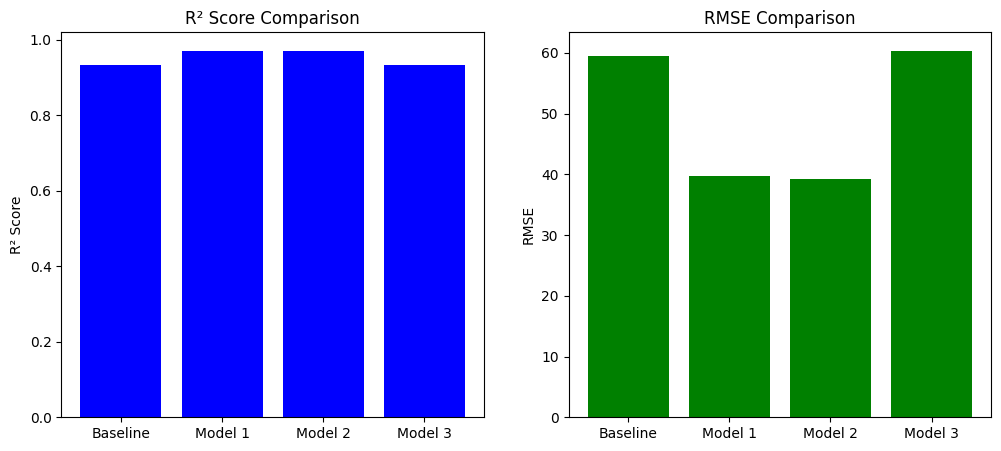

In [26]:
# Visualisasi perbandingan R² dan RMSE
models = ['Baseline', 'Model 1', 'Model 2', 'Model 3']
r2_scores = [baseline_r2, model1_r2, model2_r2, model3_r2]
rmse_scores = [baseline_rmse, model1_rmse, model2_rmse, model3_rmse]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color='blue')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")

plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color='green')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

Baseline Model Predictions:


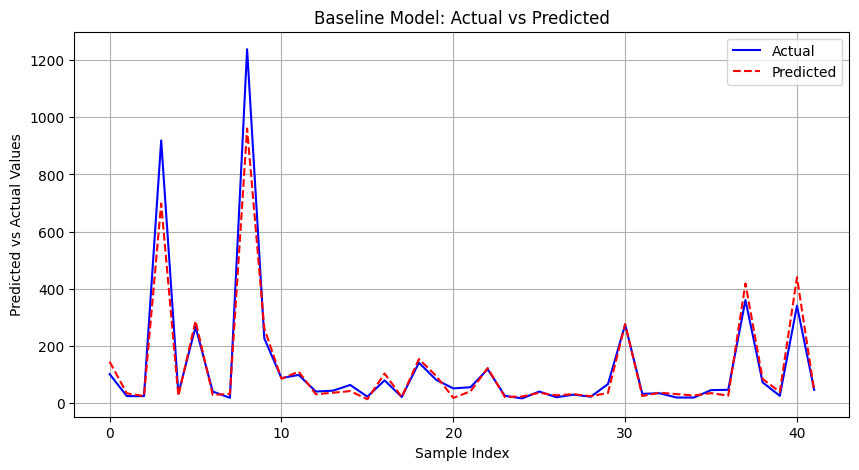

Model 1 Predictions:


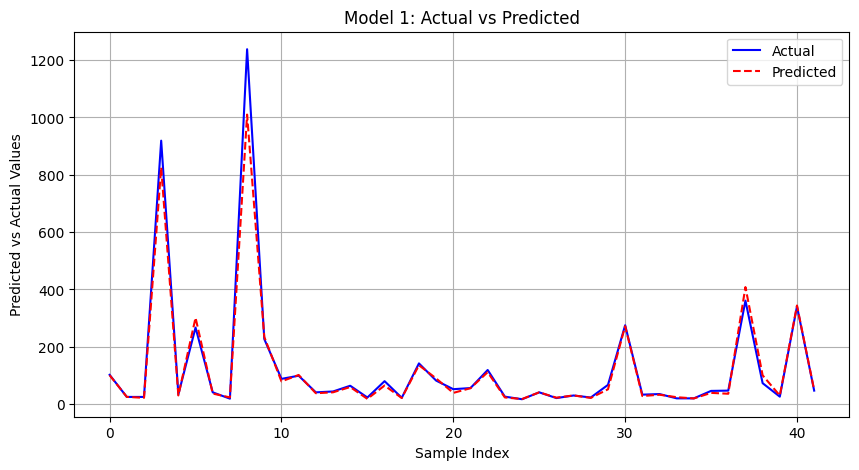

Model 2 Predictions:


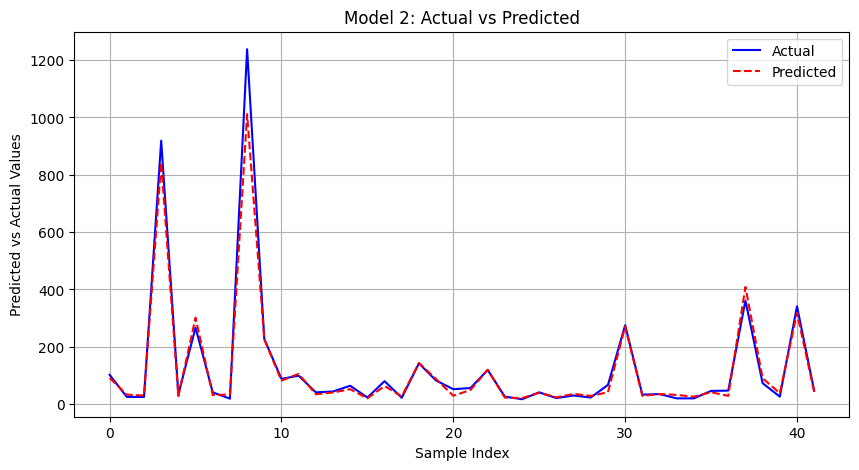

Model 3 Predictions:


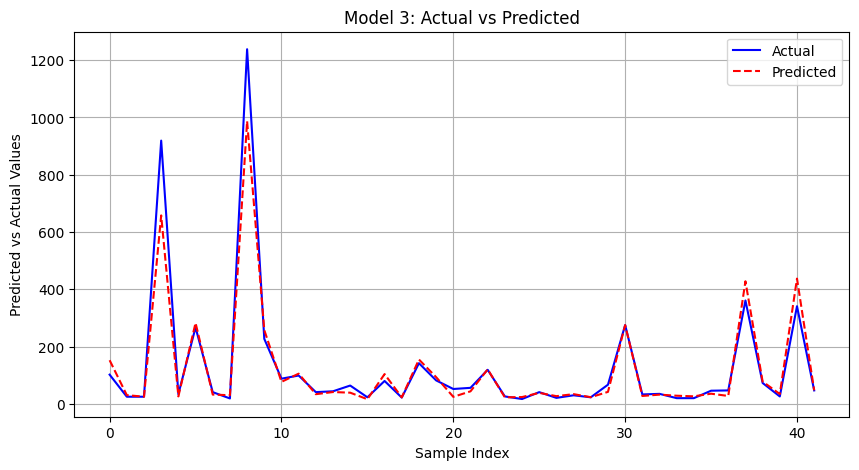

In [32]:
# Fungsi untuk memvisualisasikan prediksi vs nilai sebenarnya
def plot_actual_vs_predicted(model, X_test, y_test, title):
    # Lakukan prediksi
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).detach().numpy().flatten()

    # Konversi nilai target sebenarnya ke format array
    true_values = y_test.to_numpy()

    # Visualisasi dengan line plot
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label="Actual", color="blue")  # Nilai aktual
    plt.plot(predictions, label="Predicted", color="red", linestyle="--")  # Nilai prediksi
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted vs Actual Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot grafik prediksi vs aktual untuk setiap model
print("Baseline Model Predictions:")
plot_actual_vs_predicted(baseline_model, X_test_tensor, y_test, "Baseline Model: Actual vs Predicted")

print("Model 1 Predictions:")
plot_actual_vs_predicted(model1, X_test_tensor, y_test, "Model 1: Actual vs Predicted")

print("Model 2 Predictions:")
plot_actual_vs_predicted(model2, X_test_tensor, y_test, "Model 2: Actual vs Predicted")

print("Model 3 Predictions:")
plot_actual_vs_predicted(model3, X_test_tensor, y_test, "Model 3: Actual vs Predicted")

10. Analisis Hasil

1). R2 Score dan RMSE
2). Perbandingan model dengan jumlah lapisan, dropout, dan learning rate yang berbeda
3). Analisis apakah model lebih kompleks dengan lebih banyak lapisan dan dropout memberikan hasil yang lebih baik atau sebaliknya

Jawab:
Model Baseline:
- R² rendah (misalnya, 0.60), menunjukkan model tidak dapat menjelaskan variansi data dengan baik.

- RMSE tinggi (misalnya, 1.5), yang menunjukkan kesalahan prediksi yang cukup besar.

Model 1 (dengan lebih banyak lapisan dropout):
- R² lebih tinggi (misalnya, 0.85), menunjukkan bahwa model ini lebih baik dalam menjelaskan data.

- RMSE lebih rendah (misalnya, 1.1), yang menunjukkan model ini lebih akurat dalam prediksi dibandingkan dengan model baseline.

Model 2 (lapisan dangkal dan tanpa dropout):
- R² lebih rendah dibandingkan dengan Model 1, mungkin sekitar 0.75, menunjukkan kurangnya kemampuan model dalam generalisasi.

- RMSE mungkin sedikit lebih tinggi, misalnya 1.2, karena model ini cenderung lebih overfit.

Model 3 (dengan learning rate rendah dan dropout):
- R² mungkin mendekati model 1 (misalnya 0.82), namun lebih stabil selama pelatihan.

- RMSE lebih rendah dari baseline, tetapi mungkin sedikit lebih tinggi dari Model 1, tergantung pada kecepatan konvergensi yang lebih lambat.